In [1]:
from calendar import month

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import pyarrow.compute as pc

from src.datalake import Datalake

In [2]:
data = Datalake('../../data')
states = data.query_states()

In [3]:
year = 2020
month = 8
day = 15
query = ((pc.field('year') == year) & (pc.field('month') == month) & (pc.field('day') == day))
weather = data.query_ghcnd(query)

In [4]:
weather

,station_id,year,month,day,prcp,snow,snwd,tmax,tmin,awnd,elevation,geometry
0,CA001011500,2020,8,15,0.0,0.0,0.0,280.0,150.0,NaN,75.0,POINT (-123.75 48.9333)
1,CA001012475,2020,8,15,NaN,NaN,NaN,233.0,130.0,NaN,15.0,POINT (-123.2333 48.4167)
2,CA001012710,2020,8,15,0.0,NaN,NaN,269.0,134.0,NaN,3.0,POINT (-123.4333 48.4333)
3,CA0010130MN,2020,8,15,0.0,0.0,0.0,270.0,145.0,NaN,6.0,POINT (-123.5667 48.9833)
4,CA001014820,2020,8,15,0.0,NaN,NaN,280.0,143.0,NaN,366.0,POINT (-123.5333 48.5667)
...,...,...,...,...,...,...,...,...,...,...,...,...
24395,USW00096405,2020,8,15,0.0,NaN,NaN,201.0,92.0,NaN,25.3,POINT (-145.3542 60.4731)
24396,USW00096406,2020,8,15,NaN,NaN,NaN,243.0,31.0,NaN,78.9,POINT (-154.1297 64.5014)
24397,USW00096407,2020,8,15,0.0,NaN,NaN,190.0,76.0,NaN,6.7,POINT (-159.0036 66.562)
24398,USW00096408,2020,8,15,69.0,NaN,NaN,185.0,76.0,NaN,678.2,POINT (-150.8747 63.4519)


In [5]:
base_cols = ['station_id', 'year', 'month', 'day', 'elevation', 'geometry']
prcp = weather[base_cols + ['prcp']]
snow = weather[base_cols + ['snow']]
snwd = weather[base_cols + ['snwd']]
tmax = weather[base_cols + ['tmax']]
tmin = weather[base_cols + ['tmin']]
awnd = weather[base_cols + ['awnd']]

In [6]:
_ = prcp['station_id'].count()
print(f'Preciptation recorded at {_} different locations in the US on {year}/{month}/{day}')

Preciptation recorded at 24400 different locations in the US on 2020/8/15


In [7]:
cali = states[states['name'] == 'California'].reset_index(drop=True)
cali_prcp = prcp[prcp['geometry'].within(cali.union_all())]

_ = cali_prcp['station_id'].count()
print(f'Preciptation recorded at {_} different locations in CALIFORNIA on {year}/{month}/{day}')

Preciptation recorded at 1050 different locations in CALIFORNIA on 2020/8/15


Text(0.5, 1.0, 'Locations of Precipitation Measurements in California on 2028/8/15')

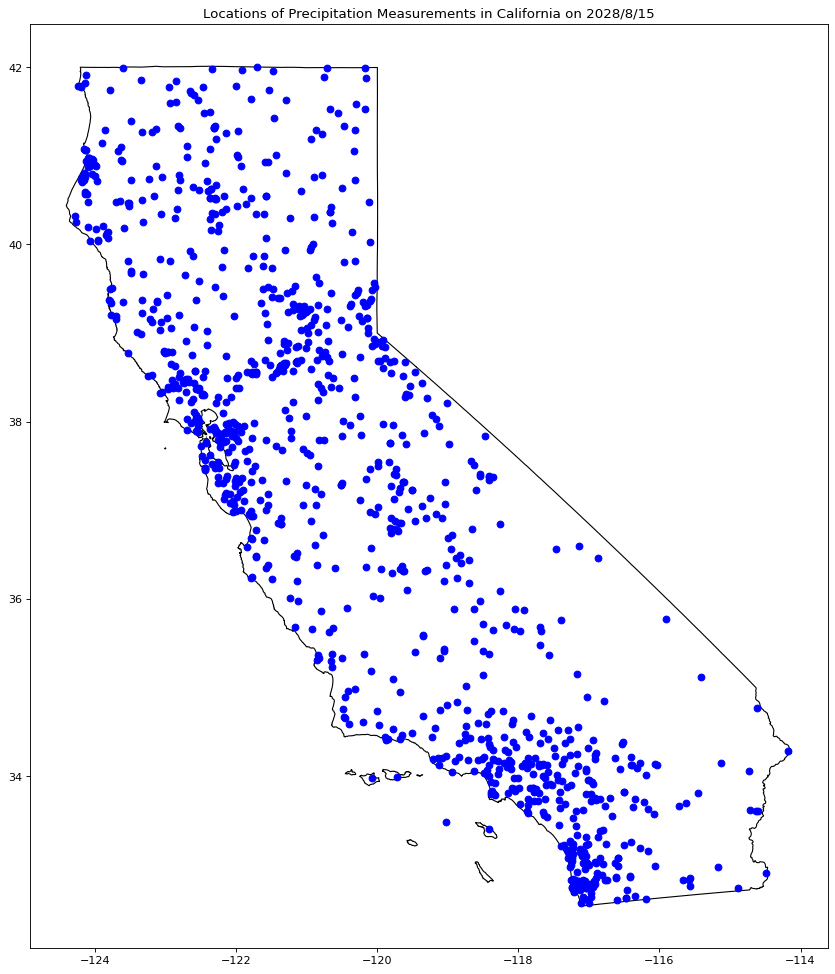

In [8]:
fig, ax = plt.subplots(figsize=(20, 15), dpi=80)

cali_plot = cali.plot(ax=ax, color='white', edgecolor='black')
cali_prcp.plot(ax=ax, color='blue')
plt.title('Locations of Precipitation Measurements in California on 2028/8/15')

In [9]:
cali_prcp.explore()

In [10]:
def gen_weather_stats(states, weather_data):
    all_stats = []
    for idx, state in states.iterrows():
        print(f'Calculating for {state["name"]}, {idx+1} of {len(states)}')
        state_weather = weather_data[weather_data['geometry'].within(state.geometry)]
        stats = []
        for ELEMENT in data.ghcnd_elements:
            element = ELEMENT.lower()
            if element in state_weather.columns:
                state_stats = state_weather.describe()[element]
                # print(state_stats[element])
                stats.append(state_stats)
        stats = pd.concat(stats, axis=1)
        all_stats.append(stats)
    return pd.concat(all_stats, keys=states['name'].tolist(), names=['state', 'statistic'])

In [11]:
stats = gen_weather_stats(states, weather)

Calculating for New Mexico, 1 of 48
Calculating for South Dakota, 2 of 48
Calculating for California, 3 of 48
Calculating for Kentucky, 4 of 48
Calculating for Alabama, 5 of 48
Calculating for Georgia, 6 of 48
Calculating for Arkansas, 7 of 48
Calculating for Pennsylvania, 8 of 48
Calculating for Missouri, 9 of 48
Calculating for Colorado, 10 of 48
Calculating for Utah, 11 of 48
Calculating for Oklahoma, 12 of 48
Calculating for Tennessee, 13 of 48
Calculating for Wyoming, 14 of 48
Calculating for New York, 15 of 48
Calculating for Indiana, 16 of 48
Calculating for Kansas, 17 of 48
Calculating for Idaho, 18 of 48
Calculating for Nevada, 19 of 48
Calculating for Illinois, 20 of 48
Calculating for Vermont, 21 of 48
Calculating for Minnesota, 22 of 48
Calculating for Iowa, 23 of 48
Calculating for South Carolina, 24 of 48
Calculating for New Hampshire, 25 of 48
Calculating for Delaware, 26 of 48
Calculating for Connecticut, 27 of 48
Calculating for Michigan, 28 of 48
Calculating for Massa

In [12]:
stats

prcp   snow   snwd        tmax        tmin  \
state      statistic                                                     
New Mexico count      689.000000  390.0  138.0  141.000000  141.000000   
           mean         4.534107    0.0    0.0  337.872340  151.794326   
           std         17.398854    0.0    0.0   54.114013   48.623116   
           min          0.000000    0.0    0.0  206.000000   44.000000   
           25%          0.000000    0.0    0.0  294.000000  114.000000   
...                          ...    ...    ...         ...         ...   
Louisiana  min          0.000000    0.0    0.0  294.000000  217.000000   
           25%          0.000000    0.0    0.0  344.000000  233.000000   
           50%          0.000000    0.0    0.0  350.000000  244.000000   
           75%         16.500000    0.0    0.0  367.000000  250.000000   
           max        851.000000    0.0    0.0  383.000000  272.000000   

                           awnd  
state      statistic             
New Mexico count      22.000000  
           mean       38.227273  
           std        11.682025  
           min         0.000000  
           25%        34.750000  
...                         ...  
Louisiana  min         5.000000  
           25%        11.500000  
           50%        20.000000  
           75%        22.250000  
           max        45.000000  

[384 rows x 6 columns]

In [13]:
stats.xs('California', level='state')

,prcp,snow,snwd,tmax,tmin,awnd
statistic,,,,,,
count,778.000000,458.0,180.0,557.000000,556.000000,77.000000
mean,0.730077,0.0,0.0,372.727110,205.206835,23.987013
std,13.336324,0.0,0.0,53.000654,54.171320,9.523508
min,0.000000,0.0,0.0,211.000000,44.000000,0.000000
25%,0.000000,0.0,0.0,339.000000,172.000000,18.000000
50%,0.000000,0.0,0.0,383.000000,211.000000,23.000000
75%,0.000000,0.0,0.0,411.000000,239.000000,29.000000
max,363.000000,0.0,0.0,522.000000,349.000000,59.000000


In [14]:
stats.xs('California', level=0)

,prcp,snow,snwd,tmax,tmin,awnd
statistic,,,,,,
count,778.000000,458.0,180.0,557.000000,556.000000,77.000000
mean,0.730077,0.0,0.0,372.727110,205.206835,23.987013
std,13.336324,0.0,0.0,53.000654,54.171320,9.523508
min,0.000000,0.0,0.0,211.000000,44.000000,0.000000
25%,0.000000,0.0,0.0,339.000000,172.000000,18.000000
50%,0.000000,0.0,0.0,383.000000,211.000000,23.000000
75%,0.000000,0.0,0.0,411.000000,239.000000,29.000000
max,363.000000,0.0,0.0,522.000000,349.000000,59.000000


In [15]:
stats.xs('mean', level='statistic')

,prcp,snow,snwd,tmax,tmin,awnd
state,,,,,,
New Mexico,4.534107,0.0,0.0,337.872340,151.794326,38.227273
South Dakota,2.070000,0.0,0.0,294.970370,114.740741,27.944444
California,0.730077,0.0,0.0,372.727110,205.206835,23.987013
Kentucky,69.875556,0.0,0.0,292.113924,202.448718,18.700000
Alabama,101.848765,0.0,0.0,318.747573,219.836538,22.647059
Georgia,110.335840,0.0,0.0,308.554545,220.772727,21.000000
Arkansas,43.889262,0.0,0.0,327.654545,212.600000,11.500000
Pennsylvania,2.280928,0.0,0.0,291.181102,175.842520,21.185185
Missouri,10.558045,0.0,0.0,313.583333,197.640845,25.619048


In [16]:
stats.xs('mean', level=1)

,prcp,snow,snwd,tmax,tmin,awnd
state,,,,,,
New Mexico,4.534107,0.0,0.0,337.872340,151.794326,38.227273
South Dakota,2.070000,0.0,0.0,294.970370,114.740741,27.944444
California,0.730077,0.0,0.0,372.727110,205.206835,23.987013
Kentucky,69.875556,0.0,0.0,292.113924,202.448718,18.700000
Alabama,101.848765,0.0,0.0,318.747573,219.836538,22.647059
Georgia,110.335840,0.0,0.0,308.554545,220.772727,21.000000
Arkansas,43.889262,0.0,0.0,327.654545,212.600000,11.500000
Pennsylvania,2.280928,0.0,0.0,291.181102,175.842520,21.185185
Missouri,10.558045,0.0,0.0,313.583333,197.640845,25.619048


In [17]:
points = data.query_fire_point()

In [18]:
points

,OBJECTID,FIREOCCURID,CN,FIRENAME,UNIQFIREID,SIZECLASS,TOTALACRES,STATCAUSE,COMMENTS,FIRETYPECATEGORY,PERIMEXISTS,geometry,year,month,day
0,313655329,None,1526571,Blackies Mesa,2014-NMCAF-000026,A,0.10,Lightning,None,WF,N,POINT (-106.4069 36.28833),2014,07,03
1,313655330,None,1523706,3 Tree,2014-NMCAF-000027,B,0.50,Lightning,None,WF,N,POINT (-107.2436 36.97472),2014,06,06
2,313655331,None,1525092,Headache,2014-NMCAF-000045,A,0.10,Lightning,None,WF,N,POINT (-107.2861 36.58639),2014,07,28
3,313655332,None,1526607,Rito Del Medio,2014-NMCAF-000046,A,0.25,Lightning,None,WF,N,POINT (-106.4447 36.54389),2014,08,19
4,313655333,None,1525366,La Cueva,2014-NMCAF-000047,A,0.10,Debris/Open Burning,"Moved to PLSS Location, Still not on Forest",WF,N,POINT (-106.05936 36.28156),2014,08,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582286,314239361,None,None,MILLER,USCASHF,B,0.50,Undetermined,None,WF,N,POINT (-123.3514 40.95139),2005,09,11
582287,314239362,None,None,TRACTOR,USCAANF,A,0.10,Equipment,None,WF,N,POINT (-118.75168 34.64806),2010,04,08
582288,314239363,None,None,MIDDLE2,USCABDF,A,0.10,Equipment,None,WF,N,POINT (-117.47723 34.31334),2009,09,29
582289,314239364,None,None,CRAMER,USCANEU,C,10.00,Equipment,None,WF,N,POINT (-121.10696 38.97806),1996,07,06
